In [1]:
# import libraries
import pandas as pd
import numpy as np
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.backend import clear_session

In [2]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

EDA was completed in previous notebook

In [3]:
# Seperate x and y values for training set
# Cast the values inside of the data frame as approrpiate data type
y = train.label.values.astype('int32')
x = train.drop(columns=['label']).values.astype('float32')
print('training set shape: {}'.format(x.shape))
print('training labels shape: {}'.format(y.shape))

training set shape: (42000, 784)
training labels shape: (42000,)


In [4]:
# Normalize data and reshape to a 3-d array
scale = np.max(x)
x_norm = x/scale

# Cast test dataframe into a numpy array
test = test.values.astype('float32')
test_norm = test/scale

x_norm = x_norm.reshape(-1,28,28,1)
test_norm = test_norm.reshape(-1,28,28,1)

x_norm.shape, test_norm.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

In [5]:
# Perform categorical encoding on the training labels
num_categories = 10
y = keras.utils.to_categorical(y, num_categories)

In [6]:
# Split the data
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_norm,y,random_state=69)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(31500, 28, 28, 1) (31500, 10)
(10500, 28, 28, 1) (10500, 10)


In [7]:
# Create function to build a cnn and return the untrained model
def base_cnn():
    model = Sequential()
    # Input layer is conv layer with kernel size of 3
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1))) # Expect input to be a b/w image 28x28 px
    model.add(Conv2D(32, kernel_size=3, activation='relu')) # Hidden layer
    # Flatten model from 2d to 1d
    model.add(Flatten())
    model.add(Dense(10, activation='softmax')) # Output layer
    # Return the model
    return model

In [8]:
# Create a cnn model with batch normalization
def batch_norm_cnn():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1))) # Expect input to be a b/w image 28x28 px
    # Recentre and re-scale inputs
    model.add(BatchNormalization())
    # Partition data into 2x2 fixed windows and take the max value from each section to create a new array
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu")) # Hidden layer
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    # Flatten the output to 1-d
    model.add(Flatten())
    # Dense layers for classification
    model.add(Dense(units=10, activation="softmax"))
    return model

In [9]:
# Create model and view summary
base_cnn = base_cnn()
base_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 10)                184330    
                                                                 
Total params: 203,434
Trainable params: 203,434
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile and train
base_cnn.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
cnn_hist = base_cnn.fit(
    x_train, y_train, epochs=10, verbose=1, validation_data=(x_val, y_val))

Epoch 1/10
985/985 [==============================] - 11s 6ms/step - loss: 0.1723 - accuracy: 0.9484 - val_loss: 0.0779 - val_accuracy: 0.9772
Epoch 2/10
985/985 [==============================] - 6s 6ms/step - loss: 0.0574 - accuracy: 0.9825 - val_loss: 0.0604 - val_accuracy: 0.9811
Epoch 3/10
985/985 [==============================] - 5s 5ms/step - loss: 0.0378 - accuracy: 0.9878 - val_loss: 0.0733 - val_accuracy: 0.9785
Epoch 4/10
985/985 [==============================] - 5s 5ms/step - loss: 0.0265 - accuracy: 0.9917 - val_loss: 0.0668 - val_accuracy: 0.9810
Epoch 5/10
985/985 [==============================] - 5s 5ms/step - loss: 0.0164 - accuracy: 0.9944 - val_loss: 0.0671 - val_accuracy: 0.9834
Epoch 6/10
985/985 [==============================] - 6s 6ms/step - loss: 0.0155 - accuracy: 0.9945 - val_loss: 0.0748 - val_accuracy: 0.9819
Epoch 7/10
985/985 [==============================] - 6s 6ms/step - loss: 0.0094 - accuracy: 0.9969 - val_loss: 0.0864 - val_accuracy: 0.9814
Epoch

In [41]:
# Print the metrics    
loss,accuracy = base_cnn.evaluate(x_train,y_train,verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss,accuracy = base_cnn.evaluate(x_val, y_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.9967
Validation Accuracy: 0.9798


In [11]:
import sys
sys.path.append('C:\\Users\\Chris\\Desktop\\ml-env\\scripts')
from plot_history import plot_history

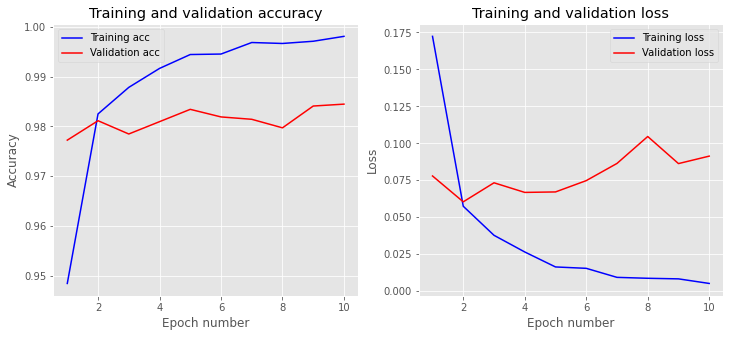

In [12]:
plot_history(cnn_hist)

In [13]:
clear_session()

In [14]:
# Load model with batch normalization and train it
bn_cnn = batch_norm_cnn()
bn_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                        

In [15]:
# Compile and train
bn_cnn.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
bn_cnn_hist = bn_cnn.fit(
    x_train, y_train, epochs=10, verbose=1, validation_data=(x_val, y_val))

Epoch 1/10
985/985 [==============================] - 7s 6ms/step - loss: 0.1519 - accuracy: 0.9530 - val_loss: 0.0735 - val_accuracy: 0.9781
Epoch 2/10
985/985 [==============================] - 6s 6ms/step - loss: 0.0559 - accuracy: 0.9823 - val_loss: 0.0705 - val_accuracy: 0.9789
Epoch 3/10
985/985 [==============================] - 6s 6ms/step - loss: 0.0414 - accuracy: 0.9864 - val_loss: 0.0813 - val_accuracy: 0.9779
Epoch 4/10
985/985 [==============================] - 6s 6ms/step - loss: 0.0290 - accuracy: 0.9907 - val_loss: 0.0604 - val_accuracy: 0.9830
Epoch 5/10
985/985 [==============================] - 6s 6ms/step - loss: 0.0225 - accuracy: 0.9925 - val_loss: 0.0692 - val_accuracy: 0.9821
Epoch 6/10
985/985 [==============================] - 6s 6ms/step - loss: 0.0194 - accuracy: 0.9933 - val_loss: 0.0639 - val_accuracy: 0.9840
Epoch 7/10
985/985 [==============================] - 6s 6ms/step - loss: 0.0173 - accuracy: 0.9940 - val_loss: 0.1178 - val_accuracy: 0.9725
Epoch 

In [42]:
# Print the metrics    
loss,accuracy = bn_cnn.evaluate(x_train,y_train,verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss,accuracy = bn_cnn.evaluate(x_val, y_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.9966
Validation Accuracy: 0.9843


The batch normalization and pooling layers helped improve the validation acc by about 1%.

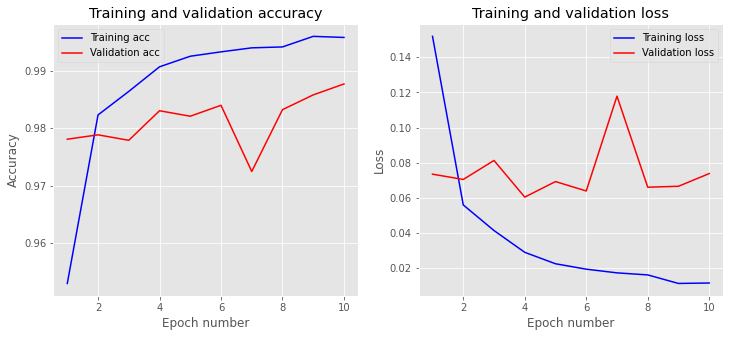

In [16]:
plot_history(bn_cnn_hist)

In [43]:
from predictions import get_preds
get_preds(base_cnn,test_norm,'submissions//base_cnn_preds.csv')
get_preds(bn_cnn, test_norm, 'submissions//batch_norm_cnn_preds.csv')